### 0/ Import

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocess, split and metric
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,plot_confusion_matrix,precision_recall_curve,roc_curve,make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# classifier algo
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC

#random
np.random.seed(42)
import random
random.seed(42)

# Settings
import warnings
warnings.filterwarnings("ignore")
import time
pd.set_option('display.max_columns', None)

from joblib import dump, load

In [2]:
#!conda install -c conda-forge py-xgboost
import xgboost as xgb

#### Tree base function

In [3]:
# Database to store result
df_accuracy = pd.DataFrame(columns=['Model name', 'Model arch.', 'Train Accuracy', 'Test_Accuracy', 'Time'])

In [4]:
# Base models
def model_performance(name, model):
    start = time.time()
    
    # fit and make prediction 
    model.fit(X_train,y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # calculate accuracy
    accuracy_train = round(accuracy_score(y_train, y_hat_train),5)
    accuracy_test = round(accuracy_score(y_test, y_hat_test),5)
    training_time = round(time.time()-start,2)
    
    # print result
    #print('Train Accuracy:', accuracy_train)
    #print('Test  Accuracy:', accuracy_test)
    #print('Training time:', training_time,'s')
    
    # store result
    df_accuracy.loc[len(df_accuracy.index)] = [name, model, accuracy_train, accuracy_test, training_time]
    return df_accuracy.loc[len(df_accuracy.index)-1]

In [5]:
# Base models
def model_performance_fat(name, model):
    start = time.time()
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    # calculate accuracy
    accuracy_train = round(accuracy_score(y_train, y_hat_train),5)
    accuracy_test = round(accuracy_score(y_test, y_hat_test),5)
    training_time = round(time.time()-start,2)
    
    # print result
    #print('Train Accuracy:', accuracy_train)
    #print('Test  Accuracy:', accuracy_test)
    #print('Training time:', training_time,'s')
    
    # store result
    df_accuracy.loc[len(df_accuracy.index)] = [name, model, accuracy_train, accuracy_test, training_time]
    return df_accuracy.loc[len(df_accuracy.index)-1]

In [6]:
def make_CF( 
    y_test, 
    y_hat, 
    group_names=None, 
    categories='auto', 
    count=True, 
    percent=True, 
    cbar=True, 
    xyticks=True, 
    xyplotlabels=True, 
    sum_stats=True, 
    figsize=None, 
    cmap='Blues', 
    title=None): 
    cf = confusion_matrix(y_test, y_hat) 
    blanks = ['' for i in range(cf.size)] 
    if group_names and len(group_names)==cf.size: 
        group_labels = ["{}\n".format(value) for value in group_names] 
    else: 
        group_labels = blanks 
    if count: 
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()] 
    else: 
        group_counts = blanks 
    if percent: 
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)] 
    else: 
        group_percentages = blanks 
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)] 
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1]) 
    if figsize==None: 
        figsize = plt.rcParams.get('figure.figsize') 
    if xyticks==False: 
        categories=False 
    # MAKE THE HEATMAP VISUALIZATION 
    plt.figure(figsize=figsize) 
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories) 
     
    if title: 
        plt.title(title) 
    plt.show() 
    print(classification_report(y_test,y_hat))

#### Data

In [7]:
df = pd.read_csv('2.0 df_KNN_imputed.csv')
df.drop(columns = ['ID'], inplace=True)
df.head()

,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor,Female,Loyal Customer,52.0,Business Travel,Business,272,0.0,5.0
1,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good,Male,Loyal Customer,48.0,Personal Travel,Eco,2200,9.0,0.0
2,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent,Female,Loyal Customer,43.0,Business Travel,Business,1061,77.0,119.0
3,0,Acceptable,Ordinary,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable,Female,Loyal Customer,44.0,Business Travel,Business,780,13.0,18.0
4,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good,Female,Loyal Customer,50.0,Business Travel,Business,1981,0.0,0.0


### 1/ Prep

In [8]:
#Convert rating to numeric first
standard_rating = ['Seat_Comfort',
                   'Arrival_Time_Convenient',
                   'Catering',
                   'Onboard_Wifi_Service',
                   'Onboard_Entertainment',
                   'Online_Support',
                   'Ease_of_Online_Booking',
                   'Onboard_Service',
                   'Legroom',
                   'Baggage_Handling',
                   'CheckIn_Service',
                   'Cleanliness',
                   'Online_Boarding']

for col in standard_rating:
    df[col].replace(['Excellent', 'Good', 'Acceptable', 'Needs Improvement', 'Poor', 'Extremely Poor'],
                    [5, 4, 3, 2, 1, 0], inplace = True)
df['Platform_Location'].replace(['Very Convenient', 'Convenient', 'Manageable', 'Needs Improvement', 'Inconvenient','Very Inconvenient'], 
                                [5,4,3,2,1,0], inplace = True)

In [9]:
# Creating list of dummy columns
to_get_dummies1 = ['Seat_Class','Customer_Type','Type_Travel','Gender', 'Travel_Class',]
df = pd.get_dummies(data = df, columns = to_get_dummies1, drop_first = True)  

Y = df['Overall_Experience']
X = df.drop(columns = ['Overall_Experience'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=14)


### Base model

#### Build

In [10]:
DTree_base = DecisionTreeClassifier(random_state = 14)

In [11]:
RF_base = RandomForestClassifier(random_state = 14)

#### Loop through

In [12]:
model_list = [DTree_base,RF_base]
model_name = ['DTree_base', 'RF_base']

In [13]:
for model_name, model in zip(model_name,model_list):
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=14)
    #scaler = preprocessing.StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    print(model_performance(model_name, model))
    print('-'*90)
    print('_'*90)

print('Done.')

Model name                                     DTree_base
Model arch.       DecisionTreeClassifier(random_state=14)
Train Accuracy                                        1.0
Test_Accuracy                                     0.93357
Time                                                 0.45
Name: 0, dtype: object
------------------------------------------------------------------------------------------
__________________________________________________________________________________________
Model name                                                  RF_base
Model arch.       (DecisionTreeClassifier(max_features='sqrt', r...
Train Accuracy                                                  1.0
Test_Accuracy                                               0.95571
Time                                                           7.82
Name: 1, dtype: object
------------------------------------------------------------------------------------------
___________________________________________________

In [14]:
df_accuracy

,Model name,Model arch.,Train Accuracy,Test_Accuracy,Time
0,DTree_base,DecisionTreeClassifier(random_state=14),1.0,0.93357,0.45
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0,0.95571,7.82


<AxesSubplot: xlabel='Importance'>

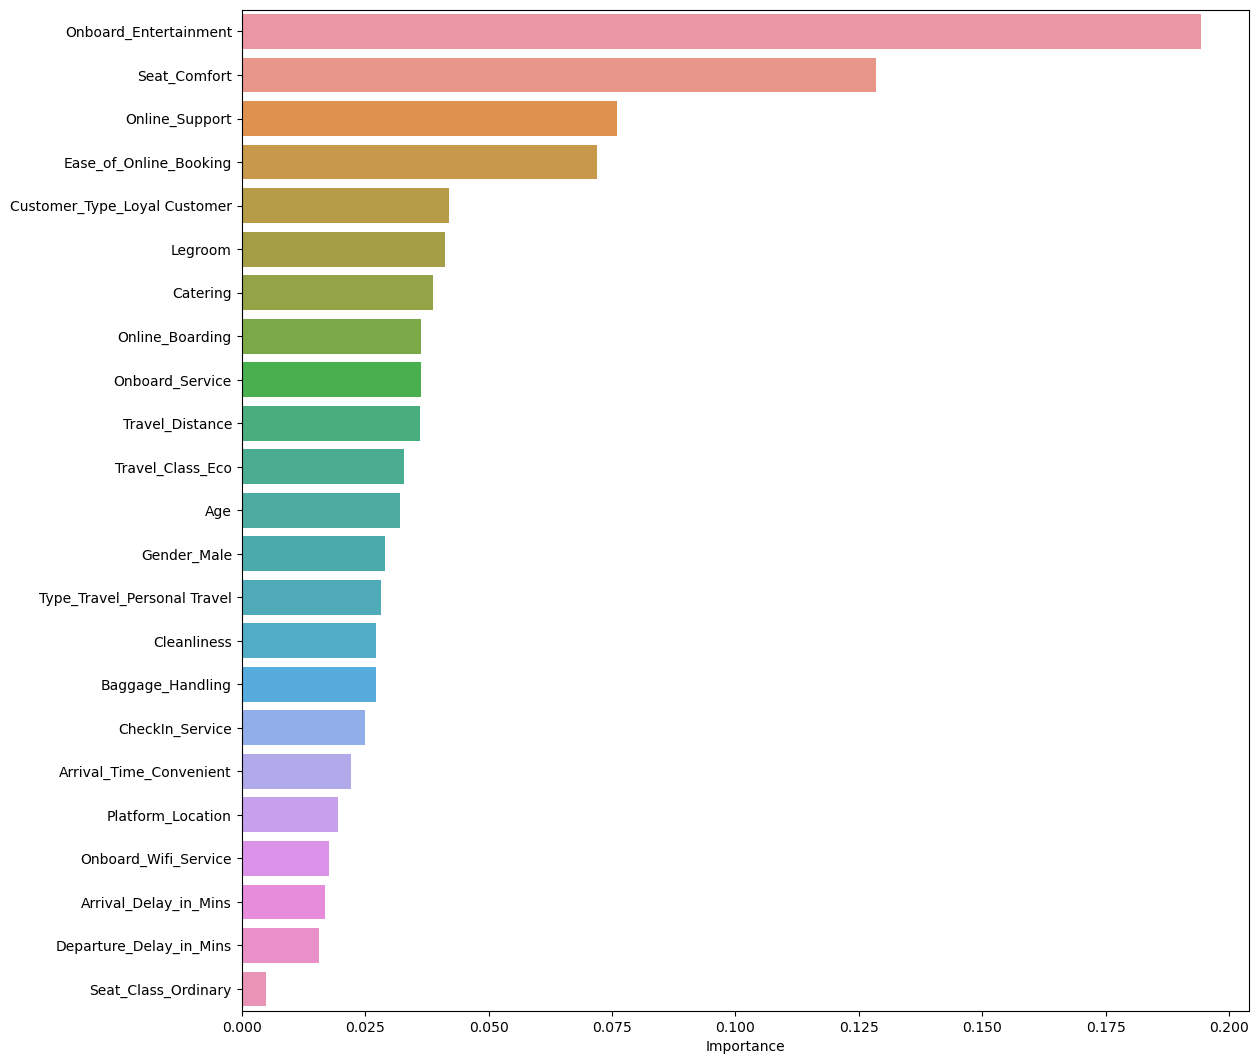

In [15]:
importance_df = pd.DataFrame(RF_base.feature_importances_,
                             index = X.columns, 
                             columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (13, 13))
sns.barplot(x=importance_df['Importance'], y=importance_df.index)

In [16]:
len(importance_df.index)

23

In [17]:
importance_df.index[0:23]

Index(['Onboard_Entertainment', 'Seat_Comfort', 'Online_Support',
       'Ease_of_Online_Booking', 'Customer_Type_Loyal Customer', 'Legroom',
       'Catering', 'Online_Boarding', 'Onboard_Service', 'Travel_Distance',
       'Travel_Class_Eco', 'Age', 'Gender_Male', 'Type_Travel_Personal Travel',
       'Cleanliness', 'Baggage_Handling', 'CheckIn_Service',
       'Arrival_Time_Convenient', 'Platform_Location', 'Onboard_Wifi_Service',
       'Arrival_Delay_in_Mins', 'Departure_Delay_in_Mins',
       'Seat_Class_Ordinary'],
      dtype='object')

**Select features**

In [18]:
#feature_limit from 7-13
feature_limit_range = np.arange(7,21)

for feature_limit in feature_limit_range:
    print('FEATURE LIMIT:',feature_limit)
    X = df.drop(columns = ['Overall_Experience'])
    X = X[importance_df.index[:feature_limit]]
    X = X.values.astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=14)

    #scaler = preprocessing.StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    RF_limit = RandomForestClassifier(random_state = 14)
    RF_limit.fit(X_train,y_train)
    y_hat_train = RF_limit.predict(X_train)
    y_hat_test = RF_limit.predict(X_test)
    
    # calculate accuracy
    accuracy_train = round(accuracy_score(y_train, y_hat_train),5)
    accuracy_test = round(accuracy_score(y_test, y_hat_test),5)
    
    # print result
    print('features:',feature_limit)
    print("Train/Test Accuracy:", accuracy_train, ' | ', accuracy_test)
    print('-'*50)

FEATURE LIMIT: 7
features: 7
Train/Test Accuracy: 0.92455  |  0.90819
--------------------------------------------------
FEATURE LIMIT: 8
features: 8
Train/Test Accuracy: 0.9353  |  0.91608
--------------------------------------------------
FEATURE LIMIT: 9
features: 9
Train/Test Accuracy: 0.94696  |  0.91974
--------------------------------------------------
FEATURE LIMIT: 10
features: 10
Train/Test Accuracy: 0.99959  |  0.91513
--------------------------------------------------
FEATURE LIMIT: 11
features: 11
Train/Test Accuracy: 0.99979  |  0.92366
--------------------------------------------------
FEATURE LIMIT: 12
features: 12
Train/Test Accuracy: 0.99997  |  0.93298
--------------------------------------------------
FEATURE LIMIT: 13
features: 13
Train/Test Accuracy: 1.0  |  0.936
--------------------------------------------------
FEATURE LIMIT: 14
features: 14
Train/Test Accuracy: 1.0  |  0.94024
--------------------------------------------------
FEATURE LIMIT: 15
features: 15
Tr

### RF hyper tuning

In [19]:
# Number of trees in random forest
n_estimators = np.arange(200,801,60).tolist()

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = np.arange(1,10).tolist()
# max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [20]:
start = time.time() #136.41 s

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print('Completed in: ', round(time.time()-start,2),'s')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Completed in:  141.74 s


In [21]:
rf_random.best_params_

{'n_estimators': 740,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': False}

In [22]:
RF_tune1 = rf_random.best_estimator_

In [23]:
model_performance('RF_tune1', RF_tune1)

Model name                                                 RF_tune1
Model arch.       (DecisionTreeClassifier(max_depth=9, max_featu...
Train Accuracy                                              0.92606
Test_Accuracy                                                0.9226
Time                                                           45.1
Name: 2, dtype: object

In [24]:
df_accuracy

,Model name,Model arch.,Train Accuracy,Test_Accuracy,Time
0,DTree_base,DecisionTreeClassifier(random_state=14),1.00000,0.93357,0.45
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",1.00000,0.95571,7.82
2,RF_tune1,"(DecisionTreeClassifier(max_depth=9, max_featu...",0.92606,0.92260,45.10


### XGBoost

In [25]:
X = df.drop(columns = ['Overall_Experience'])
X = X.values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=14)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
XGB_1 = xgb.XGBClassifier(objective='binary:logistic', seed=14)
XGB_1.fit(X_train, y_train, verbose = 2,
          early_stopping_rounds=10,
          eval_metric='aucpr',
          eval_set=[(X_test, y_test)],
         )

[0]	validation_0-aucpr:0.96436
[2]	validation_0-aucpr:0.97792
[4]	validation_0-aucpr:0.98151
[6]	validation_0-aucpr:0.98509
[8]	validation_0-aucpr:0.98701
[10]	validation_0-aucpr:0.98840
[12]	validation_0-aucpr:0.98938
[14]	validation_0-aucpr:0.98979
[16]	validation_0-aucpr:0.99012
[18]	validation_0-aucpr:0.99097
[20]	validation_0-aucpr:0.99167
[22]	validation_0-aucpr:0.99186
[24]	validation_0-aucpr:0.99228
[26]	validation_0-aucpr:0.99254
[28]	validation_0-aucpr:0.99298
[30]	validation_0-aucpr:0.99308
[32]	validation_0-aucpr:0.99342
[34]	validation_0-aucpr:0.99347
[36]	validation_0-aucpr:0.99362
[38]	validation_0-aucpr:0.99369
[40]	validation_0-aucpr:0.99381
[42]	validation_0-aucpr:0.99381
[44]	validation_0-aucpr:0.99384
[46]	validation_0-aucpr:0.99390
[48]	validation_0-aucpr:0.99406
[50]	validation_0-aucpr:0.99407
[52]	validation_0-aucpr:0.99409
[54]	validation_0-aucpr:0.99417
[56]	validation_0-aucpr:0.99416
[58]	validation_0-aucpr:0.99417
[60]	validation_0-aucpr:0.99415
[62]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=14,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=14,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [27]:
model_performance_fat('XGB_1', XGB_1)

Model name                                                    XGB_1
Model arch.       XGBClassifier(base_score=0.5, booster='gbtree'...
Train Accuracy                                              0.96654
Test_Accuracy                                               0.95502
Time                                                           0.05
Name: 3, dtype: object

### XGBoost params tuning

In [28]:
start = time.time()
random_grid = {'n_estimators' : np.arange(100,801,100).tolist(),
               'max_depth': np.arange(3,18,2),
               'learning_rate': [0.5,0.1, 0.05],
               #'gamma': [0.0, 0.25, 1.0],
               #'reg_lambda': [0.0, 1.0, 10.0],
               }
estimator = xgb.XGBClassifier(objective='binary:logistic', seed=14)
optimal_params = RandomizedSearchCV(estimator = estimator,
                                    param_distributions = random_grid,
                                    n_iter = 5, 
                                    cv = 3, 
                                    verbose=3, 
                                    random_state=42, 
                                    n_jobs = 10,
                                    scoring = 'roc_auc'
                                   )

optimal_params.fit(X_train, y_train)
print('Completed in:', round(time.time()-start,2))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[19:49:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Completed in: 89.82


In [29]:
print(optimal_params.best_params_)

{'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.1}


In [30]:
XGB_tune1 = optimal_params.best_estimator_

In [31]:
XGB_tune1.fit(X_train, y_train, verbose = 2,
          early_stopping_rounds=10,
          eval_metric='aucpr',
          eval_set=[(X_test, y_test)],
         )

[0]	validation_0-aucpr:0.98833
[2]	validation_0-aucpr:0.98976
[4]	validation_0-aucpr:0.99110
[6]	validation_0-aucpr:0.99146
[8]	validation_0-aucpr:0.99193
[10]	validation_0-aucpr:0.99221
[12]	validation_0-aucpr:0.99267
[14]	validation_0-aucpr:0.99290
[16]	validation_0-aucpr:0.99306
[18]	validation_0-aucpr:0.99323
[20]	validation_0-aucpr:0.99341
[22]	validation_0-aucpr:0.99348
[24]	validation_0-aucpr:0.99363
[26]	validation_0-aucpr:0.99370
[28]	validation_0-aucpr:0.99379
[30]	validation_0-aucpr:0.99384
[32]	validation_0-aucpr:0.99386
[34]	validation_0-aucpr:0.99396
[36]	validation_0-aucpr:0.99404
[38]	validation_0-aucpr:0.99412
[40]	validation_0-aucpr:0.99419
[42]	validation_0-aucpr:0.99424
[44]	validation_0-aucpr:0.99428
[46]	validation_0-aucpr:0.99431
[48]	validation_0-aucpr:0.99432
[50]	validation_0-aucpr:0.99434
[52]	validation_0-aucpr:0.99436
[54]	validation_0-aucpr:0.99440
[56]	validation_0-aucpr:0.99443
[58]	validation_0-aucpr:0.99445
[60]	validation_0-aucpr:0.99449
[62]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=14,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=14,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [32]:
model_performance_fat('XGB_tune1', XGB_tune1)

Model name                                                XGB_tune1
Model arch.       XGBClassifier(base_score=0.5, booster='gbtree'...
Train Accuracy                                              0.99981
Test_Accuracy                                               0.95656
Time                                                           0.15
Name: 4, dtype: object

### XGBoost params tuning 2

In [42]:
start = time.time()
random_grid = {'gamma': [0.0, 0.25, 1.0],
               'reg_lambda': [0.0, 1.0, 10.0],
               }
estimator = xgb.XGBClassifier(objective='binary:logistic', seed=14, n_estimators=200, max_depth=15,learning_rate=0.1)
optimal_params = RandomizedSearchCV(estimator = estimator,
                                    param_distributions = random_grid,
                                    n_iter = 5, 
                                    cv = 3, 
                                    verbose=3, 
                                    random_state=42, 
                                    n_jobs = 10,
                                    scoring = 'roc_auc'
                                   )

optimal_params.fit(X_train, y_train)
print('Completed in:', round(time.time()-start,2))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[19:14:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Completed in: 91.13


In [43]:
print(optimal_params.best_params_)

{'reg_lambda': 10.0, 'gamma': 1.0}


In [44]:
start = time.time()
random_grid = {'gamma': [0.1, 0.25, 0.5],
               'reg_lambda': [1.0, 10.0,100],
               }
estimator = xgb.XGBClassifier(objective='binary:logistic', seed=14, n_estimators=200, max_depth=15,learning_rate=0.1)
optimal_params = RandomizedSearchCV(estimator = estimator,
                                    param_distributions = random_grid,
                                    n_iter = 5, 
                                    cv = 3, 
                                    verbose=3, 
                                    random_state=42, 
                                    n_jobs = 10,
                                    scoring = 'roc_auc'
                                   )

optimal_params.fit(X_train, y_train)
print('Completed in:', round(time.time()-start,2))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[19:15:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Completed in: 91.77


In [45]:
print(optimal_params.best_params_)

{'reg_lambda': 10.0, 'gamma': 0.5}


In [46]:
XGB_tune2 = xgb.XGBClassifier(objective='binary:logistic', seed=14, n_estimators=200, max_depth=15,learning_rate=0.1,
                             reg_lambda = 10.0,
                              gamma = 0.5)

In [47]:
XGB_tune2.fit(X_train, y_train, verbose = 2,
          early_stopping_rounds=10,
          eval_metric='aucpr',
          eval_set=[(X_test, y_test)],
         )

[0]	validation_0-aucpr:0.97840
[2]	validation_0-aucpr:0.98367
[4]	validation_0-aucpr:0.98889
[6]	validation_0-aucpr:0.98957
[8]	validation_0-aucpr:0.99039
[10]	validation_0-aucpr:0.99080
[12]	validation_0-aucpr:0.99135
[14]	validation_0-aucpr:0.99162
[16]	validation_0-aucpr:0.99189
[18]	validation_0-aucpr:0.99212
[20]	validation_0-aucpr:0.99222
[22]	validation_0-aucpr:0.99253
[24]	validation_0-aucpr:0.99308
[26]	validation_0-aucpr:0.99331
[28]	validation_0-aucpr:0.99346
[30]	validation_0-aucpr:0.99358
[32]	validation_0-aucpr:0.99366
[34]	validation_0-aucpr:0.99376
[36]	validation_0-aucpr:0.99389
[38]	validation_0-aucpr:0.99403
[40]	validation_0-aucpr:0.99413
[42]	validation_0-aucpr:0.99419
[44]	validation_0-aucpr:0.99425
[46]	validation_0-aucpr:0.99428
[48]	validation_0-aucpr:0.99435
[50]	validation_0-aucpr:0.99444
[52]	validation_0-aucpr:0.99451
[54]	validation_0-aucpr:0.99456
[56]	validation_0-aucpr:0.99462
[58]	validation_0-aucpr:0.99465
[60]	validation_0-aucpr:0.99468
[62]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=14,
              reg_alpha=0, reg_lambda=10.0, scale_pos_weight=1, seed=14,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [48]:
model_performance_fat('XGB_tune2', XGB_tune2)

Model name                                                XGB_tune2
Model arch.       XGBClassifier(base_score=0.5, booster='gbtree'...
Train Accuracy                                                0.992
Test_Accuracy                                               0.95714
Time                                                           0.12
Name: 5, dtype: object

### Accuracy overview

In [49]:
df_accuracy

,Model name,Model arch.,Train Accuracy,Test_Accuracy,Time
0,DTree_base,DecisionTreeClassifier(random_state=14),1.00000,0.93357,0.46
1,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",1.00000,0.95571,7.76
2,RF_tune1,"(DecisionTreeClassifier(max_depth=9, max_featu...",0.92606,0.92260,43.86
3,XGB_1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.96654,0.95502,0.04
4,XGB_tune1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.99981,0.95656,0.11
5,XGB_tune2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.99200,0.95714,0.12


### Make prediction on the dataset 

#### Import df_submit

In [50]:
df_submit = pd.read_csv("2.0 df_submit_KNN_imputed.csv")
df_submit.head()

,ID,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,99900001,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor,Female,Loyal Customer,36.0,Business Travel,Business,532,0.0,0.0
1,99900002,Extremely Poor,Ordinary,Good,Poor,Manageable,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable,Female,Disloyal Customer,21.0,Business Travel,Business,1425,9.0,28.0
2,99900003,Excellent,Ordinary,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent,Male,Loyal Customer,60.0,Business Travel,Business,2832,0.0,0.0
3,99900004,Acceptable,Green Car,Excellent,Acceptable,Very Convenient,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0
4,99900005,Excellent,Ordinary,Extremely Poor,Excellent,Needs Improvement,Excellent,Excellent,Excellent,Excellent,Excellent,Acceptable,Excellent,Excellent,Excellent,Excellent,Male,Disloyal Customer,18.0,Business Travel,Business,1610,17.0,0.0


In [51]:
ID_col = df_submit['ID']
df_submit.drop(columns = ['ID'], inplace=True)
df_submit.head(1)

,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor,Female,Loyal Customer,36.0,Business Travel,Business,532,0.0,0.0


In [52]:
#Convert rating to numeric first
standard_rating = ['Seat_Comfort',
                   'Arrival_Time_Convenient',
                   'Catering',
                   'Onboard_Wifi_Service',
                   'Onboard_Entertainment',
                   'Online_Support',
                   'Ease_of_Online_Booking',
                   'Onboard_Service',
                   'Legroom',
                   'Baggage_Handling',
                   'CheckIn_Service',
                   'Cleanliness',
                   'Online_Boarding']

for col in standard_rating:
    df_submit[col].replace(['Excellent', 'Good', 'Acceptable', 'Needs Improvement', 'Poor', 'Extremely Poor'],
                    [5, 4, 3, 2, 1, 0], inplace = True)
df_submit['Platform_Location'].replace(['Very Convenient', 'Convenient', 'Manageable', 'Needs Improvement', 'Inconvenient','Very Inconvenient'], 
                                [5,4,3,2,1,0], inplace = True)
df_submit.head(5)

,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
0,3,Green Car,3,3,3,2,5,4,5,5,5,5,4,5,1,Female,Loyal Customer,36.0,Business Travel,Business,532,0.0,0.0
1,0,Ordinary,4,1,3,3,1,3,3,5,3,4,3,5,3,Female,Disloyal Customer,21.0,Business Travel,Business,1425,9.0,28.0
2,5,Ordinary,5,5,5,5,5,5,2,2,2,2,4,2,5,Male,Loyal Customer,60.0,Business Travel,Business,2832,0.0,0.0
3,3,Green Car,5,3,5,1,3,5,1,3,2,5,5,5,1,Female,Loyal Customer,29.0,Personal Travel,Eco,1352,0.0,0.0
4,5,Ordinary,0,5,2,5,5,5,5,5,3,5,5,5,5,Male,Disloyal Customer,18.0,Business Travel,Business,1610,17.0,0.0


In [53]:
# Creating list of dummy columns
to_get_dummies1 = ['Seat_Class','Customer_Type','Type_Travel','Gender', 'Travel_Class',]

# Creating dummy variables
df_submit = pd.get_dummies(data = df_submit, columns = to_get_dummies1, drop_first = True)  

In [54]:
df_submit.head(5)

,Seat_Comfort,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Class_Ordinary,Customer_Type_Loyal Customer,Type_Travel_Personal Travel,Gender_Male,Travel_Class_Eco
0,3,3,3,3,2,5,4,5,5,5,5,4,5,1,36.0,532,0.0,0.0,0,1,0,0,0
1,0,4,1,3,3,1,3,3,5,3,4,3,5,3,21.0,1425,9.0,28.0,1,0,0,0,0
2,5,5,5,5,5,5,5,2,2,2,2,4,2,5,60.0,2832,0.0,0.0,1,1,0,1,0
3,3,5,3,5,1,3,5,1,3,2,5,5,5,1,29.0,1352,0.0,0.0,0,1,1,0,1
4,5,0,5,2,5,5,5,5,5,3,5,5,5,5,18.0,1610,17.0,0.0,1,0,0,1,0


In [55]:
df_submit.shape

(35602, 23)

#### Make prediction loop

In [56]:
model_list = [(DTree_base, 'DTree_base'),
              (RF_base,'RF_base'),
              (XGB_1,'XGB_1'),
              (XGB_tune1,'XGB_tune1'),
              (XGB_tune2,'XGB_tune2')
             ]

In [57]:

for model, model_name in model_list:
    print('Exporting ',model_name,'...')
    y_hat = model.predict(df_submit)
    df_to_submit = pd.DataFrame()
    df_to_submit['ID'] = ID_col
    df_to_submit['Overall_Experience'] = y_hat
    filename = 'submission_model_' + model_name + '.csv'
    df_to_submit.to_csv(filename, index = False)
    print('Finished ',filename)
print('All finished')

Exporting  DTree_base ...
Finished  submission_model_DTree_base.csv
Exporting  RF_base ...
Finished  submission_model_RF_base.csv
Exporting  XGB_1 ...
Finished  submission_model_XGB_1.csv
Exporting  XGB_tune1 ...
Finished  submission_model_XGB_tune1.csv
Exporting  XGB_tune2 ...
Finished  submission_model_XGB_tune2.csv
All finished
